In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Max Wealth: 1099.27, Min Wealth: 901.00, Avg Wealth: 997.42
Max Risk: 390.83, Min Risk: 390.83, Avg Risk: 390.83
Max Wealth: 1087.73, Min Wealth: 904.48, Avg Wealth: 1008.81
Max Risk: 354.28, Min Risk: 354.28, Avg Risk: 354.28
Max Wealth: 1093.62, Min Wealth: 901.09, Avg Wealth: 1000.91
Max Risk: 305.67, Min Risk: 305.67, Avg Risk: 305.67
Max Wealth: 1096.86, Min Wealth: 900.25, Avg Wealth: 985.27
Max Risk: 204.75, Min Risk: 204.75, Avg Risk: 204.75
Max Wealth: 1096.56, Min Wealth: 901.59, Avg Wealth: 1008.16
Max Risk: 180.19, Min Risk: 180.19, Avg Risk: 180.19
Max Wealth: 1090.59, Min Wealth: 905.39, Avg Wealth: 1007.02
Max Risk: 319.18, Min Risk: 319.18, Avg Risk: 319.18
Max Wealth: 1098.04, Min Wealth: 917.52, Avg Wealth: 1021.97
Max Risk: 206.91, Min Risk: 206.91, Avg Risk: 206.91
Max Wealth: 1097.48, Min Wealth: 900.60, Avg Wealth: 1003.99
Max Risk: 292.16, Min Risk: 292.16, Avg Risk: 292.16
Max Wealth: 1093.85, Min Wealth: 907.92, Avg Wealth: 996.46
Max Risk: 368.67, Min Risk: 36

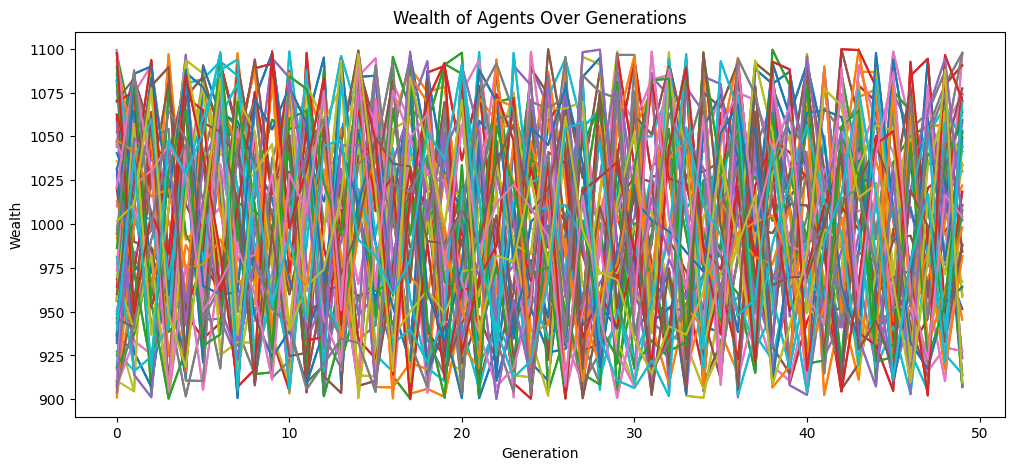

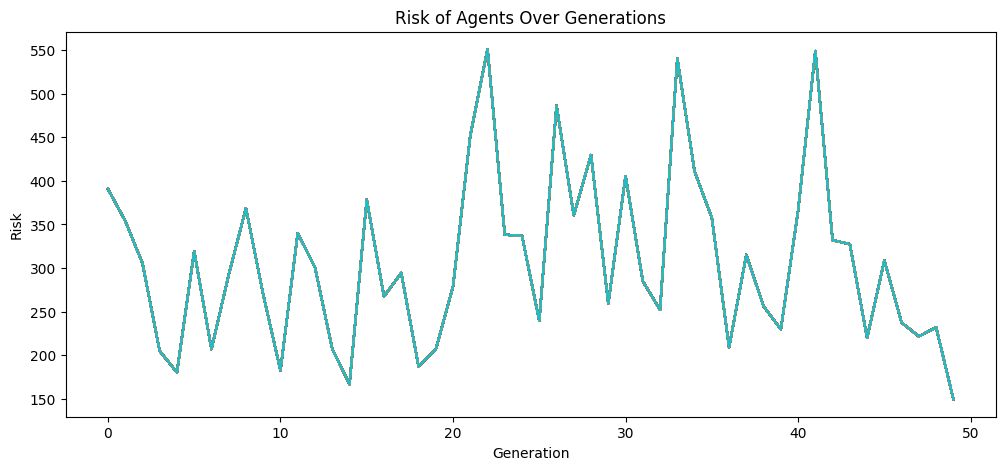

In [20]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

# Load the dataset (replace with your actual dataset path)
df = pd.read_csv("/kaggle/input/multiobj-gt/Data.csv")
stock_data = df[['Open', 'Close', 'High', 'Low']].values.tolist()

# Risk calculation based on price volatility
def calculate_risk(prices):
    return np.std(prices)  # Standard deviation as a measure of risk

# Define the Agent class for multi-objective coevolution
class Agent:
    def __init__(self, num_rules):
        self.rules = self.generate_random_rules(num_rules)
        self.wealth = 1000 + random.uniform(-100, 100)  # Random initial wealth
        self.stocks = 0
        self.risk = 0  # Initial risk

    def generate_random_rules(self, num_rules):
        rules = []
        for _ in range(num_rules):
            rule_type = random.choice(['moving_average', 'price_change', 'bollinger_bands'])
            if rule_type == 'moving_average':
                short_period = random.randint(5, 15)
                long_period = random.randint(16, 40)
                threshold = random.uniform(0.01, 0.03)
                condition = lambda state: self.moving_average_crossover(state, short_period, long_period, threshold)
            elif rule_type == 'price_change':
                threshold = random.uniform(0.01, 0.05)
                condition = lambda state: self.price_change(state, threshold)
            elif rule_type == 'bollinger_bands':
                period = random.randint(10, 20)
                std_dev = random.uniform(1.5, 2)
                condition = lambda state: self.bollinger_bands(state, period, std_dev)
            action = random.choice(['buy', 'sell', 'hold'])
            rules.append([condition, action])  # Storing rules as lists instead of tuples
        return rules

    def moving_average_crossover(self, state, short_period, long_period, threshold):
        if len(state) < long_period:
            return False
        short_ma = np.mean([s[1] for s in state[-short_period:]])
        long_ma = np.mean([s[1] for s in state[-long_period:]])
        return abs(short_ma - long_ma) / long_ma > threshold

    def price_change(self, state, threshold):
        if len(state) < 2:
            return False
        return abs(state[-1][1] - state[-2][1]) / state[-2][1] > threshold

    def bollinger_bands(self, state, period, std_dev):
        if len(state) < period:
            return False
        prices = [s[1] for s in state[-period:]]
        ma = np.mean(prices)
        std = np.std(prices)
        upper_band = ma + std_dev * std
        lower_band = ma - std_dev * std
        return state[-1][1] > upper_band or state[-1][1] < lower_band

    def make_decision(self, state):
        for condition, action in self.rules:
            if condition(state):
                return action
        return 'hold'

# Define the Simulation class for Multi-Objective Coevolutionary Algorithm
class Simulation:
    def __init__(self, num_agents, num_rules, stock_data):
        self.agents = [Agent(num_rules) for _ in range(num_agents)]
        self.stock_data = stock_data
        self.current_day = 0

    def run(self, num_days):
        for _ in range(num_days):
            state = self.stock_data[:self.current_day + 1]
            for agent in self.agents:
                decision = agent.make_decision(state)
                self.execute_trade(agent, decision, state)
            self.current_day += 1

    def execute_trade(self, agent, decision, state):
        current_price = state[-1][1]  # 'Close' price
        if decision == 'buy' and agent.wealth >= current_price:
            agent.stocks += 1
            agent.wealth -= current_price
        elif decision == 'sell' and agent.stocks > 0:
            agent.stocks -= 1
            agent.wealth += current_price

        # Calculate agent's risk as price volatility over a window
        recent_prices = [s[1] for s in state[-10:]]  # Last 10 days for risk calculation
        agent.risk = calculate_risk(recent_prices)

    def evolve(self):
        # Use Pareto-based selection to evolve agents based on both wealth and risk
        sorted_agents = sorted(self.agents, key=lambda x: (x.wealth, -x.risk), reverse=True)
        top_half = sorted_agents[:len(sorted_agents) // 2]
        new_agents = []
        for agent in top_half:
            new_agent = Agent(len(agent.rules))
            new_agent.rules = agent.rules  # Inherit rules
            new_agents.append(new_agent)

        # Mutate some agents' strategies
        for agent in new_agents:
            if random.random() < 0.1:
                agent.rules = self.mutate_rules(agent.rules)
        self.agents = new_agents * 2

    def mutate_rules(self, rules):
        for rule in rules:
            if random.random() < 0.3:
                rule[1] = random.choice(['buy', 'sell', 'hold'])
        return rules

    def calculate_statistics(self):
        wealths = [agent.wealth for agent in self.agents]
        risks = [agent.risk for agent in self.agents]
        max_wealth = max(wealths)
        min_wealth = min(wealths)
        avg_wealth = np.mean(wealths)
        max_risk = max(risks)
        min_risk = min(risks)
        avg_risk = np.mean(risks)

        print(f"Max Wealth: {max_wealth:.2f}, Min Wealth: {min_wealth:.2f}, Avg Wealth: {avg_wealth:.2f}")
        print(f"Max Risk: {max_risk:.2f}, Min Risk: {min_risk:.2f}, Avg Risk: {avg_risk:.2f}")

# Running the Simulation with 100 agents
num_agents = 100
num_rules = 5
num_generations = 50
days_per_generation = 5

sim = Simulation(num_agents, num_rules, stock_data)
wealth_over_time = [[] for _ in range(num_agents)]
risk_over_time = [[] for _ in range(num_agents)]

for generation in range(num_generations):
    sim.run(days_per_generation)
    sim.calculate_statistics()

    for i, agent in enumerate(sim.agents):
        wealth_over_time[i].append(agent.wealth)
        risk_over_time[i].append(agent.risk)

    sim.evolve()

# Plotting wealth and risk graphs for all agents
plt.figure(figsize=(12, 5))
for i in range(num_agents):
    plt.plot(wealth_over_time[i], label=f"Wealth of Agent {i+1}")

plt.title('Wealth of Agents Over Generations')
plt.xlabel('Generation')
plt.ylabel('Wealth')
plt.show()

plt.figure(figsize=(12, 5))
for i in range(num_agents):
    plt.plot(risk_over_time[i], label=f"Risk of Agent {i+1}")

plt.title('Risk of Agents Over Generations')
plt.xlabel('Generation')
plt.ylabel('Risk')
plt.show()

